<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/biogpt_variants_biogpt_large_nih_pubmed_qa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install scann -q

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 79.9 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd 
from platform import python_version
import os 
import sklearn
import json
# from data_loader import patent_data
# from data_diluter import normalizer
# from data_diluter import  diluted_df
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import math
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')

In [5]:
os.listdir('drive/MyDrive/transfer/biogpt_variants/biogpt_large_pubmed_qa')

['data_biotech_title_biogpt_Large_PubMedQA_norm.npy',
 'data_biotech_abstract_biogpt_Large_PubMedQA.npy',
 'data_biotech_abstract_biogpt_Large_PubMedQA_norm.npy',
 'data_biotech_title_biogpt_Large_PubMedQA.npy',
 'data_nih_title_biogpt_Large_PubMedQA.npy',
 'data_nih_abstract_biogpt_Large_PubMedQA.npy',
 'data_nih_abstract_biogpt_Large_PubMedQA_norm.npy',
 'data_nih_title_biogpt_Large_PubMedQA_norm.npy']

In [19]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit , mrr  

In [7]:
nih_abstract_biogpt_large_pubmed_qa = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large_pubmed_qa/data_nih_abstract_biogpt_Large_PubMedQA_norm.npy')
nih_title_biogpt_large_pubmed_qa = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large_pubmed_qa/data_nih_title_biogpt_Large_PubMedQA_norm.npy')

Text(0.5, 1.0, 'biogpt_large')

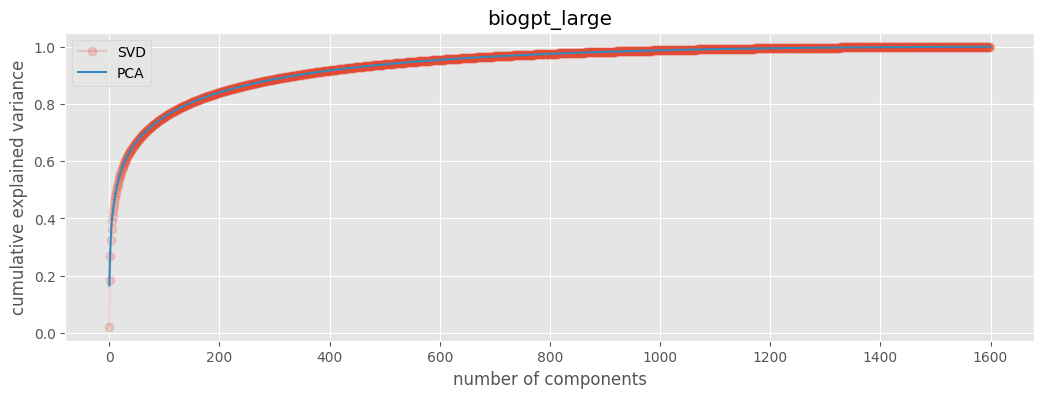

In [9]:
pca_biogpt_large = PCA().fit(nih_abstract_biogpt_large_pubmed_qa)
pca_var_nih_large = np.cumsum(pca_biogpt_large.explained_variance_ratio_)

svd_content_nih_large = TruncatedSVD(n_iter= 25, n_components = 1600 ).fit(nih_abstract_biogpt_large_pubmed_qa)
svd_var_nih_large = np.cumsum(svd_content_nih_large.explained_variance_ratio_)
     
plt.figure(figsize = (12.5,4))
plt.plot(svd_var_nih_large, marker = 'o', alpha =0.2)
plt.plot(pca_var_nih_large)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])
plt.title('biogpt_large')

In [10]:
print('PCA 100% :',np.where(np.array(pca_var_nih_large) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var_nih_large) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_nih_large) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_nih_large) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_nih_large) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_nih_large) >= 0.90)[0][0])

PCA 100% : 1059
SVD 100% : 1059
PCA 95% : 571
SVD 95% : 571
PCA 90% : 340
SVD 90% : 340


In [11]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector
     

def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save('./patent_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save('./patent_title_vectors_norm'+pca_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = svd_.inverse_transform(content_vectors_svd)
    inverse_title = svd_.inverse_transform(title_vectors_svd)

    np.save('./patent_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save('./patent_title_vectors_norm'+svd_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

In [13]:
pca_reducer(340, nih_abstract_biogpt_large_pubmed_qa, nih_title_biogpt_large_pubmed_qa)
svd_reducer(340, nih_abstract_biogpt_large_pubmed_qa, nih_title_biogpt_large_pubmed_qa)

pca_reducer(571, nih_abstract_biogpt_large_pubmed_qa, nih_title_biogpt_large_pubmed_qa)
svd_reducer(571, nih_abstract_biogpt_large_pubmed_qa, nih_title_biogpt_large_pubmed_qa)

pca_reducer(1059, nih_abstract_biogpt_large_pubmed_qa, nih_title_biogpt_large_pubmed_qa)
svd_reducer(1059, nih_abstract_biogpt_large_pubmed_qa, nih_title_biogpt_large_pubmed_qa)

In [14]:
abstract_pca_340 = np.load('./patent_abst_vectors_norm_pca_340.npy')
abstract_pca_571 = np.load('./patent_abst_vectors_norm_pca_571.npy')
abstract_pca_1059 = np.load('./patent_abst_vectors_norm_pca_1059.npy')

abstract_svd_340 = np.load('./patent_abst_vectors_norm_svd_340.npy')
abstract_svd_571 = np.load('./patent_abst_vectors_norm_svd_571.npy')
abstract_svd_1059 = np.load('./patent_abst_vectors_norm_svd_1059.npy')

title_pca_340 = np.load('./patent_title_vectors_norm_pca_340.npy')
title_pca_571 = np.load('./patent_title_vectors_norm_pca_571.npy')
title_pca_1059 = np.load('./patent_title_vectors_norm_pca_1059.npy')

title_svd_340 = np.load('./patent_title_vectors_norm_svd_340.npy')
title_svd_571 = np.load('./patent_title_vectors_norm_svd_571.npy')
title_svd_1059 = np.load('./patent_title_vectors_norm_svd_1059.npy')

In [17]:
searcher_raw = scann.scann_ops_pybind.builder(nih_abstract_biogpt_large_pubmed_qa, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_340 = scann.scann_ops_pybind.builder(abstract_pca_340, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_571 = scann.scann_ops_pybind.builder(abstract_pca_571, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_1059 = scann.scann_ops_pybind.builder(abstract_pca_1059, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()
   
  
searcher_svd_340 = scann.scann_ops_pybind.builder(abstract_svd_340, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_571 = scann.scann_ops_pybind.builder(abstract_svd_571, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_1059 = scann.scann_ops_pybind.builder(abstract_svd_1059, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    

In [18]:
raw_idx = []
reduced_idx_pca_340 = []
reduced_idx_svd_340 = []
reduced_idx_pca_571 = []
reduced_idx_svd_571 = []
reduced_idx_pca_1059 = []
reduced_idx_svd_1059 = []
# reduced_idx_pca_107 = []
# reduced_idx_svd_107 = []
for i in range(len(nih_abstract_biogpt_large_pubmed_qa)):
    raw_idx.append(searcher_raw.search(nih_title_biogpt_large_pubmed_qa[i])[0])
    reduced_idx_pca_340.append(searcher_pca_340.search(title_pca_340[i])[0])
    reduced_idx_svd_340.append(searcher_svd_340.search(title_svd_340[i])[0])
    reduced_idx_pca_571.append(searcher_pca_571.search(title_pca_571[i])[0])
    reduced_idx_svd_571.append(searcher_svd_571.search(title_svd_571[i])[0])
    reduced_idx_pca_1059.append(searcher_pca_1059.search(title_pca_1059[i])[0])
    reduced_idx_svd_1059.append(searcher_svd_1059.search(title_svd_1059[i])[0])

In [20]:
k = [1,3,5,10,15,20,30]
ap_pca_340, hit_pca_340, mrr_pca_340 = metrics_calculator(raw_idx,reduced_idx_pca_340, k )
ap_svd_340, hit_svd_340, mrr_svd_340 = metrics_calculator(raw_idx,reduced_idx_svd_340, k )

ap_pca_571, hit_pca_571, mrr_pca_571 = metrics_calculator(raw_idx,reduced_idx_pca_571, k )
ap_svd_571, hit_svd_571, mrr_svd_571 = metrics_calculator(raw_idx,reduced_idx_svd_571, k )

ap_pca_1059, hit_pca_1059, mrr_pca_1059 = metrics_calculator(raw_idx,reduced_idx_pca_1059, k )
ap_svd_1059, hit_svd_1059, mrr_svd_1059 = metrics_calculator(raw_idx,reduced_idx_svd_1059, k )

<ipython-input-19-79f078fc1687>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


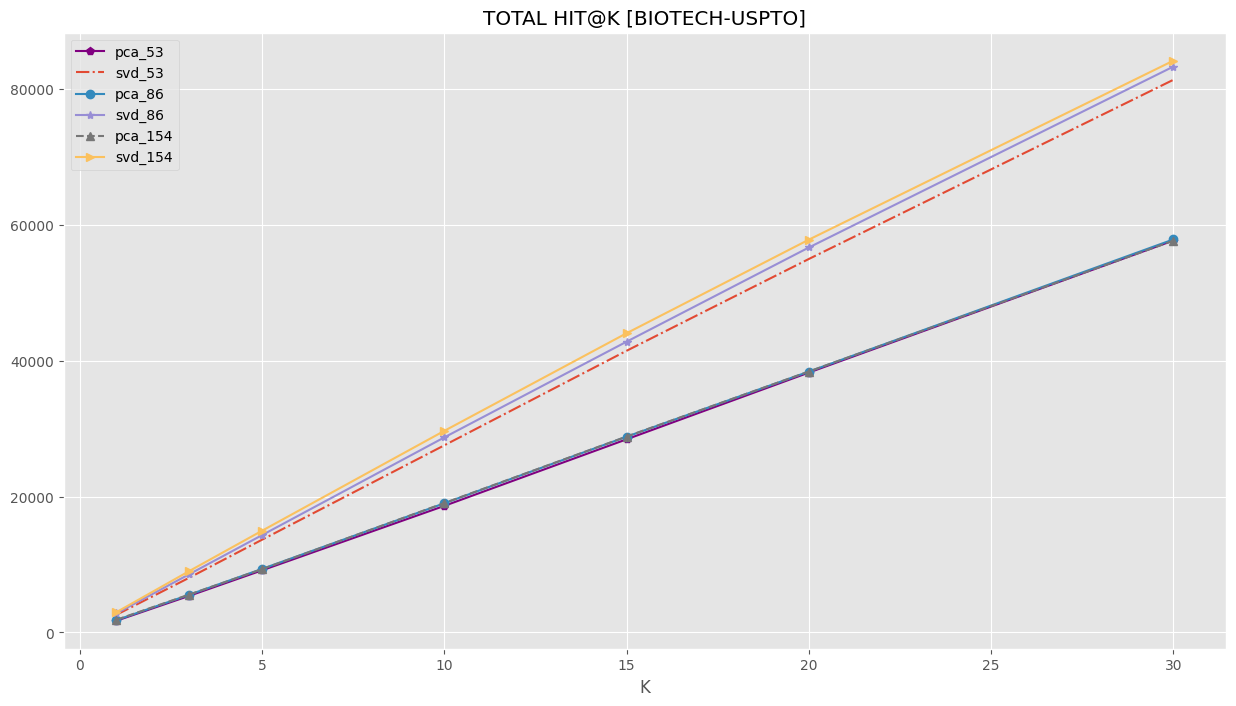

In [21]:
# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_340, '-p', color = 'purple')
plt.plot(k,hit_svd_340, '-.')
plt.plot(k,hit_pca_571, '-o')
plt.plot(k,hit_svd_571, '-*')
plt.plot(k,hit_pca_1059, '--^')
plt.plot(k,hit_svd_1059, '>-')
# plt.scatter(k,hit_pca_107, marker ='s',color= 'green')
# plt.plot(k,hit_svd_107, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K [BIOTECH-USPTO]')
plt.legend(['pca_340','svd_340','pca_571','svd_571','pca_1059','svd_1059'])
plt.xlabel('K');

In [22]:
print(hit_svd_340)
print(hit_svd_571)
print(hit_svd_1059)

[2607, 8066, 13665, 27555, 41463, 54970, 81333]
[2809, 8581, 14340, 28720, 42802, 56660, 83277]
[2990, 9045, 14987, 29681, 44046, 57814, 84148]
